# **1. Import & Setup**

This section initializes the development environment by importing necessary libraries for data manipulation, natural language processing, machine learning, and visualization. Display settings are configured and NLTK resources for Indonesian text preprocessing are downloaded.

## **1.1 Library Installation**

In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
pip install optuna

## **1.2 Library Import**

In [ ]:
# Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Standard Library
import time
import re
import json
import os
import warnings
import pickle
from datetime import datetime
from collections import Counter

warnings.filterwarnings("ignore")

# Numerical & Data Handling
import numpy as np
import pandas as pd

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, make_scorer, precision_recall_fscore_support

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

# External Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Hyperparameter Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.importance import get_param_importances

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager as fm, dates as mdates
import seaborn as sns

# Utilities
import joblib
from sklearn.utils import resample

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **1.3 Configuration & Settings**

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

mpl.rcParams['boxplot.boxprops.color'] = '#808080'
mpl.rcParams['boxplot.capprops.color'] = '#808080'
mpl.rcParams['boxplot.whiskerprops.color'] = '#808080'
mpl.rcParams['boxplot.medianprops.color'] = '#808080'
mpl.rcParams['boxplot.flierprops.color'] = '#808080'
mpl.rcParams['boxplot.meanprops.color'] = '#808080'

# **2. Data Loading  & Exploration**

The raw review dataset is loaded and exploratory analysis is conducted to understand data structure, distribution, and quality. This initial investigation informs the preprocessing strategy and identifies potential data quality issues.

## **2.1 Load Dataset**

In [ ]:
df = pd.read_csv('ulasan_org.telegram.messenger.csv')
display(df.head())

## **2.2 Basic Info & Statistics**


In [ ]:
print("Dataset Shape:", df.shape)
print("\nDataset Information:")
df.info()

In [ ]:
print("Descriptive Statistics:")
display(df.describe())

In [ ]:
print("Rating Distribution:")
print(df['Rating'].value_counts())

## **2.3 Data Quality Check**

In [ ]:
print("Missing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

# **3. Data Preprocessing**

Raw Indonesian text is transformed into clean, normalized features through multiple stages: labeling, cleaning, normalization, tokenization, stemming, and negation handling. Each step reduces noise while preserving semantic information critical for sentiment classification.

## **3.0. Labeling**

Sentiment labels are created based on rating scores: 4-5 stars as positive, 1-2 stars as negative, and 3 stars as neutral.

In [ ]:
df['sentiment'] = df['Rating'].apply(lambda x: 'positif' if x >= 4 else ('negatif' if x <= 2 else 'netral'))

print("Distribusi Sentimen")
print(df['sentiment'].value_counts())

## **3.1 Text Cleaning**

URLs, email addresses, special characters, and excessive whitespace are removed. Empty reviews are filtered out to ensure data quality.

In [ ]:
df['Ulasan'] = df['Ulasan'].fillna('').astype(str)

# Remove URLs
df['clean_review'] = df['Ulasan'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Remove email addresses
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub(r'\S+@\S+', '', x))

# Remove karakter khusus dan punctuation, keep spasi
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Remove extra whitespace
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Remove rows with empty text
df = df[df['clean_review'].str.len() > 0]
print(f"Number of records after removing empty text: {len(df)}")

## **3.2 Text Normalization**

Text is converted to lowercase and repeated characters are normalized. Indonesian slang words are mapped to their formal equivalents using a custom dictionary.

In [ ]:
# Convert text to lowercase
df['clean_review'] = df['clean_review'].str.lower()

In [ ]:
# Normalize repeated characters (limit repetitions to a maximum of two)
def normalize_repeated_characters(text, max_repeat=2):
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_review'] = df['clean_review'].apply(normalize_repeated_characters)

In [ ]:
slang_dict = {'gak': 'tidak', 'ga': 'tidak',  'g': 'tidak', 'gx': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak', 'tdk': 'tidak', 'bgt': 'banget', 'bgt': 'sangat', 'bgs': 'bagus', 'jgn': 'jangan', 'blm': 'belum', 'udh': 'sudah', 'udah': 'sudah', 'gimana': 'bagaimana', 'gmn': 'bagaimana', 'knp': 'kenapa', 'tp': 'tapi', 'tq': 'terima kasih', 'mksh': 'terima kasih', 'trmksh': 'terima kasih', 'krn': 'karena', 'krna': 'karena', 'emang': 'memang', 'emg': 'memang', 'bner': 'benar', 'bnr': 'benar', 'org': 'orang', 'jd': 'jadi', 'jdi': 'jadi', 'bs': 'bisa', 'bkn': 'bukan', 'sm': 'sama', 'dr': 'dari', 'utk': 'untuk', 'dgn': 'dengan', 'yg': 'yang', 'pd': 'pada', 'sdh': 'sudah', 'trs': 'terus', 'klo': 'kalau', 'kalo': 'kalau', 'spy': 'supaya', 'aja': 'saja', 'aj': 'saja', 'donk': 'dong', 'dong': 'dong', 'nih': 'ini', 'sih': 'sih', 'deh': 'deh', 'bro': 'bro', 'sis': 'sis', 'mantap': 'mantap', 'mantul': 'mantap', 'josss': 'bagus', 'top': 'bagus', 'jelek': 'buruk', 'parah': 'buruk', 'zonk': 'buruk', 'ampas': 'buruk'}
def normalize_slang(text):
    words = text.split()
    return ' '.join([slang_dict.get(word, word) for word in words])

df['clean_review'] = df['clean_review'].apply(normalize_slang)

## **3.3 Tokenization & Stemming**

Text is tokenized into individual words and Indonesian stemming is applied using Sastrawi to reduce words to their root forms.

In [ ]:
# Text preprocessing: tokenization and stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Tokenization & Stemming
df['tokens'] = df['clean_review'].apply(lambda x: x.split())
df['tokens_stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
df['processed_text'] = df['tokens_stemmed'].apply(lambda x: ' '.join(x))

## **3.4 Negation Handling**

Negation words and their context are detected and marked with a 'NOT_' prefix to preserve sentiment polarity in subsequent analysis.

In [ ]:
negations = {'tidak', 'tak', 'nggak', 'nga', 'enggak', 'gak', 'gx', 'bukan', 'belum', 'jangan', 'tanpa', 'kurang', 'minus', 'kecewa', 'mengecewakan', 'buruk', 'jelek', 'payah', 'ga', 'g', 'tdk', 'jgn', 'blm', 'tdk'}

def handle_negation(text, window=4):
    words = text.split()
    result = []
    negate = False
    count = 0

    for i, word in enumerate(words):
        if word in negations:
            result.append(word)
            negate = True
            count = 0
        elif negate and count < window:
            # Jangan negate stopwords umum
            if word not in {'yang', 'ini', 'itu', 'dan', 'atau'}:
                result.append(f'NOT_{word}')
            else:
                result.append(word)
            count += 1
        else:
            result.append(word)
            negate = False

    return ' '.join(result)

df['processed_text'] = df['processed_text'].apply(handle_negation)

In [ ]:
# Pastikan tidak ada nilai null atau kosong
df = df[df['processed_text'].notna()]
df = df[df['processed_text'].str.strip().str.len() > 0]
df['processed_text'] = df['processed_text'].astype(str)

print(f"✓ Final records after validation: {len(df)}")

# **4. Data Splitting**

The dataset is split into training and test sets with stratified sampling to maintain class distribution. Processed data is saved for reproducibility and future use.

In [ ]:
# Train–test split with stratified class distribution
X = df['processed_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("SPLIT RESULTS:")
print(f"Total samples: {len(df)}")
print(f"Training set: {len(X_train)} ({len(X_train) / len(df) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(df) * 100:.1f}%)")
print("\nTRAINING SET DISTRIBUTION:")
print(y_train.value_counts())
print("\nTEST SET DISTRIBUTION:")
print(y_test.value_counts())

In [ ]:
# Create train and test dataframes
train_df = pd.DataFrame({
    'processed_text': X_train.values,
    'sentiment_label': y_train.values
})

test_df = pd.DataFrame({
    'processed_text': X_test.values,
    'sentiment_label': y_test.values
})

# Save to CSV
train_path = '/content/drive/MyDrive/Colab Notebooks/Portfolio/NLP/Text Classification/Tokopedia Reviews/telegram_train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/Portfolio/NLP/Text Classification/Tokopedia Reviews/telegram_test.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("✓ Preprocessed data saved successfully!")
print(f"✓ Training data: {train_path}")
print(f"✓ Test data: {test_path}")

# **5. Modeling**

Multiple classification algorithms are evaluated through cross-validation to establish a performance baseline. The best performer undergoes hyperparameter tuning and threshold calibration to maximize predictive performance on imbalanced classes.

## **5.1. Baseline Model Comparison**

Ten different classification algorithms are compared using 3-fold stratified cross-validation. Performance metrics, training time, inference speed, and model size are evaluated to select the optimal algorithm for this task.

In [ ]:
# Load train and test data
train_df = pd.read_csv('telegram_train.csv')
test_df = pd.read_csv('telegram_test.csv')

X_train_full = train_df['processed_text']
y_train_full = train_df['sentiment_label']
X_test = test_df['processed_text']
y_test = test_df['sentiment_label']

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

In [ ]:
# Label encoding untuk multi-class
label_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
y_train = y_train.map(label_mapping)
y_val = y_val.map(label_mapping)
y_test = y_test.map(label_mapping)

print("SPLIT RESULTS:")
print(f"Training samples : {len(X_train)}")
print(f"Test samples     : {len(X_test)}")

print("\nTRAINING SET DISTRIBUTION:")
print(y_train.value_counts().sort_index())

print("\nVALIDATION SET DISTRIBUTION:")
print(y_val.value_counts().sort_index())

print("\nTEST SET DISTRIBUTION:")
print(y_test.value_counts().sort_index())

SPLIT RESULTS:
Training samples : 63456
Test samples     : 19831

TRAINING SET DISTRIBUTION:
sentiment_label
0    38371
1     3286
2    21799
Name: count, dtype: int64

VALIDATION SET DISTRIBUTION:
sentiment_label
0    9593
1     822
2    5449
Name: count, dtype: int64

TEST SET DISTRIBUTION:
sentiment_label
0    11992
1     1027
2     6812
Name: count, dtype: int64


In [ ]:
# TF-IDF Configuration
tfidf_params = {
    'max_features': 50_000,
    'min_df': 2,
    'max_df': 0.95,
    'sublinear_tf': True,
    'ngram_range': (1, 2),
    'strip_accents': 'unicode',
    'lowercase': True,
    'token_pattern': r'\b\w+\b'
}

In [ ]:
# Model Definitions
models = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', MultinomialNB())
    ]),

    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42))
    ]),

    'Decision Tree': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
    ]),

    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1))
    ]),

    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', XGBClassifier(objective='multi:softprob', num_class=3, n_estimators=100, random_state=42, eval_metric='mlogloss', n_jobs=-1))
    ]),

    'SVM (LinearSVC)': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', CalibratedClassifierCV(
            LinearSVC(class_weight='balanced', random_state=42, dual='auto', max_iter=2000)
        ))
    ]),

    'K-Nearest Neighbors': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ]),

    'Gradient Boosting': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]),

    'Multi-layer Perceptron': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True))
    ]),

    'AdaBoost': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'))
    ])
}

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_macro_scorer = make_scorer(f1_score, average='macro')

results = {
    'Model': [],
    'F1 Macro (Mean)': [],
    'F1 Macro (Std)': [],
    'Training Time (s)': [],
    'Inference Time (s)': [],
    'Model Size (MB)': []
}

print("CROSS-VALIDATION 3-FOLD EVALUATION")

for model_name, pipeline in models.items():
    print(f"\nEvaluating: {model_name}")
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=f1_macro_scorer, n_jobs=-1, return_train_score=False)

    f1_mean = cv_results['test_score'].mean()
    f1_std = cv_results['test_score'].std()

    print(f"F1 Macro Scores per fold: {cv_results['test_score']}")
    print(f"F1 Macro Mean: {f1_mean:.4f}")
    print(f"F1 Macro Std: {f1_std:.4f}")

    start_train = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_train
    print(f"Training Time: {training_time:.4f} seconds")

    start_inference = time.time()
    _ = pipeline.predict(X_test)
    inference_time = time.time() - start_inference
    print(f"Inference Time: {inference_time:.4f} seconds")

    model_bytes = pickle.dumps(pipeline)
    model_size_mb = len(model_bytes) / (1024 * 1024)
    print(f"Model Size: {model_size_mb:.2f} MB")

    results['Model'].append(model_name)
    results['F1 Macro (Mean)'].append(f1_mean)
    results['F1 Macro (Std)'].append(f1_std)
    results['Training Time (s)'].append(training_time)
    results['Inference Time (s)'].append(inference_time)
    results['Model Size (MB)'].append(model_size_mb)

CROSS-VALIDATION 3-FOLD EVALUATION

Evaluating: Naive Bayes
F1 Macro Scores per fold: [0.58248662 0.57964702 0.57837139]
F1 Macro Mean: 0.5802
F1 Macro Std: 0.0017
Training Time: 3.1956 seconds
Inference Time: 0.5164 seconds
Model Size: 4.25 MB

Evaluating: Logistic Regression
F1 Macro Scores per fold: [0.64080236 0.63503763 0.63940069]
F1 Macro Mean: 0.6384
F1 Macro Std: 0.0025
Training Time: 24.3433 seconds
Inference Time: 0.5456 seconds
Model Size: 3.11 MB

Evaluating: Decision Tree
F1 Macro Scores per fold: [0.58776679 0.58983147 0.59199865]
F1 Macro Mean: 0.5899
F1 Macro Std: 0.0017
Training Time: 53.2073 seconds
Inference Time: 0.5033 seconds
Model Size: 3.55 MB

Evaluating: Random Forest
F1 Macro Scores per fold: [0.59969169 0.59247042 0.59502126]
F1 Macro Mean: 0.5957
F1 Macro Std: 0.0030
Training Time: 633.4156 seconds
Inference Time: 2.1899 seconds
Model Size: 280.63 MB

Evaluating: XGBoost
F1 Macro Scores per fold: [0.58903599 0.58392231 0.58751203]
F1 Macro Mean: 0.5868
F1 

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Macro (Mean)', ascending=False).reset_index(drop=True)

print("SUMMARY OF ALL MODELS")
print(results_df.to_string(index=False))

print("\nBEST MODEL")
best_model = results_df.iloc[0]
print(f"Model: {best_model['Model']}")
print(f"F1 Macro: {best_model['F1 Macro (Mean)']:.4f} (±{best_model['F1 Macro (Std)']:.4f})")
print(f"Training Time: {best_model['Training Time (s)']:.4f} seconds")
print(f"Inference Time: {best_model['Inference Time (s)']:.4f} seconds")
print(f"Model Size: {best_model['Model Size (MB)']:.2f} MB")

SUMMARY OF ALL MODELS
                 Model  F1 Macro (Mean)  F1 Macro (Std)  Training Time (s)  Inference Time (s)  Model Size (MB)
   Logistic Regression         0.638414        0.002455          24.343345            0.545576         3.106537
         Random Forest         0.595728        0.002990         633.415552            2.189906       280.629530
Multi-layer Perceptron         0.592468        0.001347         914.168119            0.615192       116.531114
       SVM (LinearSVC)         0.591984        0.000936         204.405929            0.582191         7.686782
         Decision Tree         0.589866        0.001728          53.207339            0.503292         3.550297
               XGBoost         0.586823        0.002144         156.572242            1.221916         2.593360
           Naive Bayes         0.580168        0.001720           3.195633            0.516375         4.250834
     Gradient Boosting         0.555756        0.003903         254.629387        

## **5.2. Hyperparameter Optimization**

Optuna is used to optimize Logistic Regression hyperparameters through Bayesian optimization. The search space includes regularization strength, penalty type, and class weighting strategies. Model performance is tracked across trials to identify the optimal configuration.

In [ ]:
X_sampled, _, y_sampled, _ = train_test_split(X_train, y_train, train_size=0.5, stratify=y_train, random_state=42)

def objective_logreg(trial):
    params_logreg = {
        'C': trial.suggest_float('C', 10e-3, 10e2, log=True),
        'penalty': 'l2',
        'solver': 'lbfgs',
        'max_iter': 1000,
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'multi_class': 'multinomial',
        'random_state': 42,
        'n_jobs': -1
    }

    try:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', LogisticRegression(**params_logreg))
        ])

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_sampled, y_sampled)):
            X_fold_train = X_sampled.iloc[train_idx]
            y_fold_train = y_sampled.iloc[train_idx]
            X_fold_val = X_sampled.iloc[val_idx]
            y_fold_val = y_sampled.iloc[val_idx]

            pipeline.fit(X_fold_train, y_fold_train)
            y_pred = pipeline.predict(X_fold_val)

            fold_score = f1_score(y_fold_val, y_pred, average='macro')
            scores.append(fold_score)

            trial.report(fold_score, fold_idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

        return np.mean(scores)

    except Exception as e:
        print(f"Trial {trial.number} failed: {str(e)}")
        raise optuna.TrialPruned()

print("\nLOGISTIC REGRESSION TUNING (50% SAMPLING)")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=1, interval_steps=1))
study.enqueue_trial({'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'solver': 'lbfgs', 'max_iter': 1000, 'multi_class': 'multinomial'})
study.optimize(objective_logreg, n_trials=25, show_progress_bar=True)

print(f"\nBest F1 Macro: {study.best_value:.4f}")
print(f"Completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print("\nBest Logistic Regression Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-01-10 07:10:26,338] A new study created in memory with name: no-name-75b3322c-e7ad-4e5c-ae73-5973b3a6c996



LOGISTIC REGRESSION TUNING (50% SAMPLING)


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-01-10 07:10:42,060] Trial 0 finished with value: 0.6352139263636039 and parameters: {'C': 1.0, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6352139263636039.
[I 2026-01-10 07:10:53,554] Trial 1 finished with value: 0.6345011968988259 and parameters: {'C': 0.7459343285726545, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6352139263636039.
[I 2026-01-10 07:11:11,242] Trial 2 finished with value: 0.6219110239001298 and parameters: {'C': 9.846738873614559, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6352139263636039.
[I 2026-01-10 07:11:18,907] Trial 3 finished with value: 0.597451514826857 and parameters: {'C': 0.0195172246414495, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6352139263636039.
[I 2026-01-10 07:11:37,565] Trial 4 finished with value: 0.6061451606347891 and parameters: {'C': 34.70266988650411, 'class_weight': None}. Best is trial 0 with value: 0.6352139263636039.
[I 2026-01-10 07:12:00,469] Trial 5 finished with

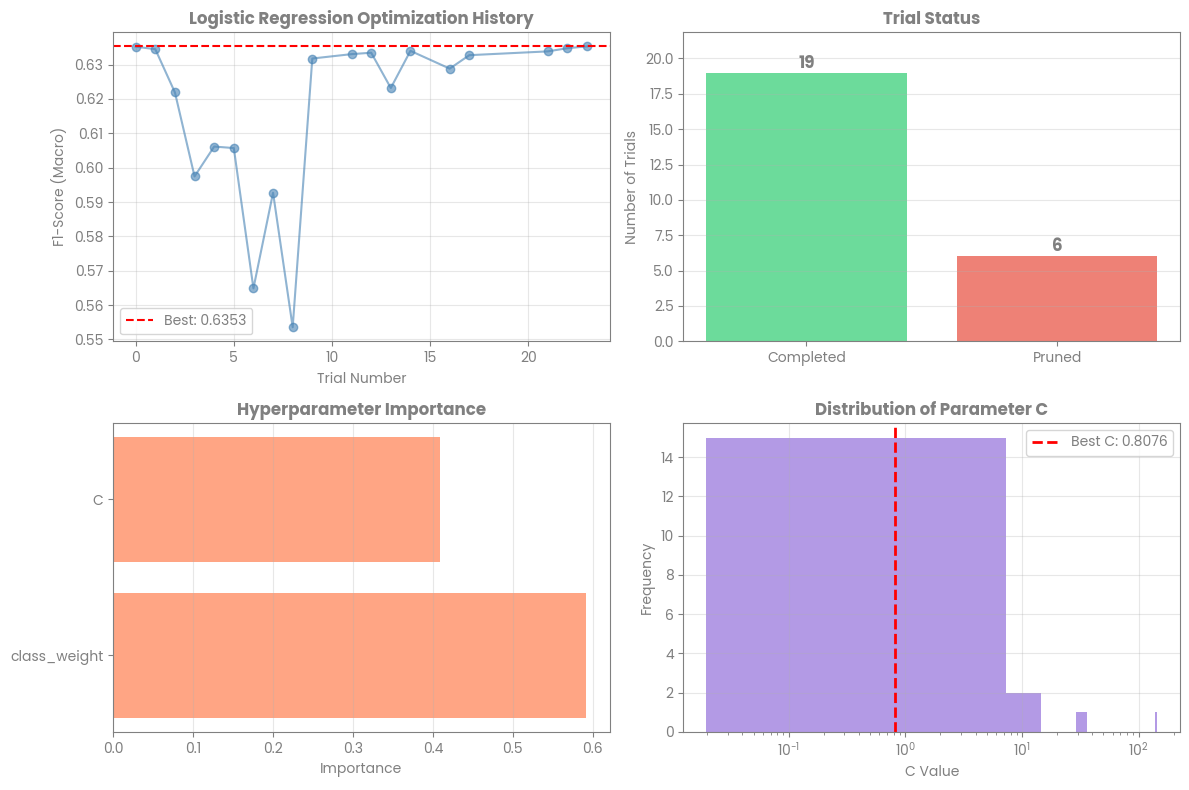

In [ ]:
# Visualization of Logistic Regression optimization results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Optimization History
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
trial_numbers = [t.number for t in completed_trials]
trial_values = [t.value for t in completed_trials]

axes[0, 0].plot(trial_numbers, trial_values, 'o-', alpha=0.6, color='steelblue')
axes[0, 0].axhline(y=study.best_value, color='red', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('F1-Score (Macro)')
axes[0, 0].set_title('Logistic Regression Optimization History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Trial States
states = {
    'Completed': len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]),
    'Pruned': len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])
}

colors = ['#2ecc71', '#e74c3c']
axes[0, 1].bar(states.keys(), states.values(), color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Number of Trials')
axes[0, 1].set_title('Trial Status')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].margins(y=0.15)

# Add value labels on top of bars
for i, (key, value) in enumerate(states.items()):
    axes[0, 1].text(i, value, str(value), ha='center', va='bottom', fontweight='bold', color='#808080', fontsize=12)

# 3. Parameter Importance
if len(completed_trials) >= 10:
    try:
        importance = optuna.importance.get_param_importances(study)
        params = list(importance.keys())
        values = list(importance.values())

        axes[1, 0].barh(params, values, color='coral', alpha=0.7)
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_title('Hyperparameter Importance')
        axes[1, 0].grid(True, alpha=0.3, axis='x')
    except:
        axes[1, 0].text(0.5, 0.5, 'Parameter importance\nnot available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Hyperparameter Importance')
else:
    axes[1, 0].text(0.5, 0.5, 'At least 10 trials are required\nto compute importance', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Hyperparameter Importance')

# 4. Distribution of the Best Parameter (C value)
c_values = [t.params.get('C') for t in completed_trials if 'C' in t.params]
if c_values:
    axes[1, 1].hist(c_values, bins=20, color='mediumpurple', alpha=0.7)
    axes[1, 1].axvline(x=study.best_params['C'], color='red', linestyle='--', linewidth=2, label=f'Best C: {study.best_params["C"]:.4f}')
    axes[1, 1].set_xlabel('C Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Parameter C')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Train Final Model on All Data
print("TRAINING FINAL MODEL ON ALL DATA")

best_params = study.best_params.copy()
solver = 'lbfgs'
penalty = 'l2'
l1_ratio = best_params.pop('l1_ratio', None)
final_params = {
    'C': best_params['C'],
    'penalty': 'l2',
    'solver': 'lbfgs',
    'max_iter': 1000,
    'class_weight': best_params['class_weight'],
    'multi_class': 'multinomial',
    'random_state': 42,
    'n_jobs': -1
}

final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(**final_params))
])

# Cross-Validation on Train Set
print("\nCross-Validation Evaluation on Train Set")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_pipeline, X_train, y_train, cv=cv, scoring='f1_macro',n_jobs=-1)

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train Final Model on entire Train Set
print("\nTraining Final Model on entire Train Set")
final_pipeline.fit(X_train, y_train)

# Evaluation on Validation Set
print("\nEvaluation on Validation Set")
y_pred_val = final_pipeline.predict(X_val)
final_f1 = f1_score(y_val, y_pred_val, average='macro')
final_accuracy = accuracy_score(y_val, y_pred_val)

print(f"Validation Set F1 Score (macro): {final_f1:.4f}")
print(f"Validation Set Accuracy: {final_accuracy:.4f}")

# Classification Report for per-class details
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val))

TRAINING FINAL MODEL ON ALL DATA

Cross-Validation Evaluation on Train Set
Cross-Validation F1 Scores: [0.64232165 0.63501588 0.63913109]
Mean CV F1 Score: 0.6388 (+/- 0.0060)

Training Final Model on entire Train Set

Evaluation on Validation Set
Validation Set F1 Score (macro): 0.6402
Validation Set Accuracy: 0.8038

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      9593
           1       0.14      0.34      0.20       822
           2       0.89      0.82      0.85      5449

    accuracy                           0.80     15864
   macro avg       0.64      0.66      0.64     15864
weighted avg       0.86      0.80      0.83     15864



## **5.3. Decision Threshold Calibration**

Default classification thresholds are optimized for each class to handle imbalanced data. Optuna searches for class-specific thresholds that maximize macro F1-score, improving performance on minority classes without sacrificing overall accuracy.

In [ ]:
final_pipeline.fit(X_train, y_train)
y_proba_val = final_pipeline.predict_proba(X_val)

Number of classes: 3
Classes: [0 1 2]


[I 2026-01-10 07:36:29,137] A new study created in memory with name: no-name-cf32275e-fea0-474f-92a2-c25be6a58f0c


BASELINE (Default Threshold)
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      9593
           1       0.14      0.34      0.20       822
           2       0.89      0.82      0.85      5449

    accuracy                           0.80     15864
   macro avg       0.64      0.66      0.64     15864
weighted avg       0.86      0.80      0.83     15864


Optimizing Thresholds with Optuna


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-01-10 07:36:29,177] Trial 0 finished with value: 0.651051803579015 and parameters: {'threshold_0': 0.9367182020405163, 'threshold_1': 1.9162143208968574, 'threshold_2': 1.5443897010793888}. Best is trial 0 with value: 0.651051803579015.
[I 2026-01-10 07:36:29,196] Trial 1 finished with value: 0.5952048243383722 and parameters: {'threshold_0': 1.3177194231349623, 'threshold_1': 0.565231688752142, 'threshold_2': 0.5651906845715444}. Best is trial 0 with value: 0.651051803579015.
[I 2026-01-10 07:36:29,212] Trial 2 finished with value: 0.6175426099292513 and parameters: {'threshold_0': 0.39874214068593905, 'threshold_1': 1.7724994478173899, 'threshold_2': 1.321895519963455}. Best is trial 0 with value: 0.651051803579015.
[I 2026-01-10 07:36:29,225] Trial 3 finished with value: 0.4719210877537255 and parameters: {'threshold_0': 1.5037233822532774, 'threshold_1': 0.33499364030286416, 'threshold_2': 1.9488467486753904}. Best is trial 0 with value: 0.651051803579015.
[I 2026-01-10 07:

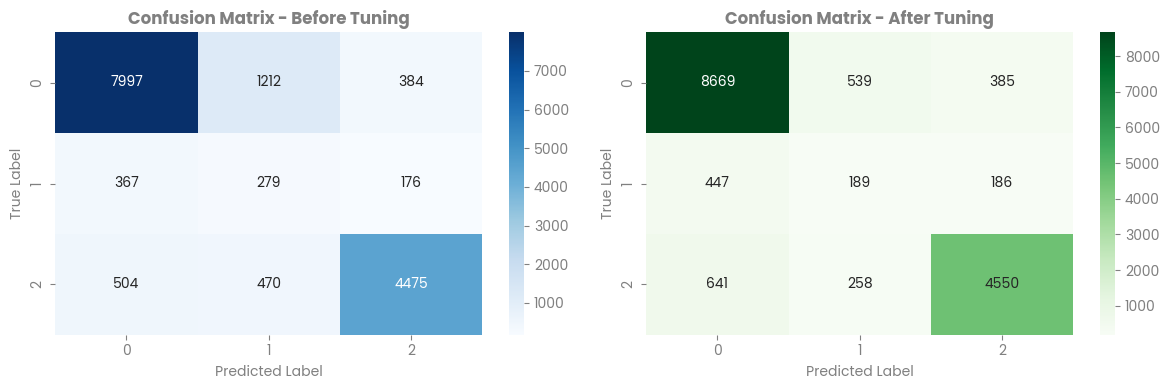

In [ ]:
# Threshold Tuning untuk Multiclass
classes = final_pipeline.classes_
n_classes = len(classes)

print(f"Number of classes: {n_classes}")
print(f"Classes: {classes}")

y_pred_baseline = final_pipeline.predict(X_val)
print("BASELINE (Default Threshold)")
print(classification_report(y_val, y_pred_baseline))

def predict_with_thresholds(y_proba, thresholds):
    adjusted_proba = y_proba / thresholds
    return classes[np.argmax(adjusted_proba, axis=1)]

def objective_threshold(trial):
    thresholds = np.array([trial.suggest_float(f'threshold_{i}', 0.3, 2.0) for i in range(n_classes)])

    y_pred = predict_with_thresholds(y_proba_val, thresholds)
    return f1_score(y_val, y_pred, average='macro')

print("\nOptimizing Thresholds with Optuna")
study_threshold = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_threshold.optimize(objective_threshold, n_trials=200, show_progress_bar=True)

print(f"\nBest F1-Score: {study_threshold.best_value:.4f}")
print("\nBest Thresholds per Class:")
best_thresholds = np.array([study_threshold.best_params[f'threshold_{i}'] for i in range(n_classes)])
for i, class_name in enumerate(classes):
    print(f"  Class {class_name}: {best_thresholds[i]:.3f}")

y_pred_tuned = predict_with_thresholds(y_proba_val, best_thresholds)

print("\nAFTER THRESHOLD TUNING")
print(classification_report(y_val, y_pred_tuned))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_before = confusion_matrix(y_val, y_pred_baseline)
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix - Before Tuning')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_after = confusion_matrix(y_val, y_pred_tuned)
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix - After Tuning')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

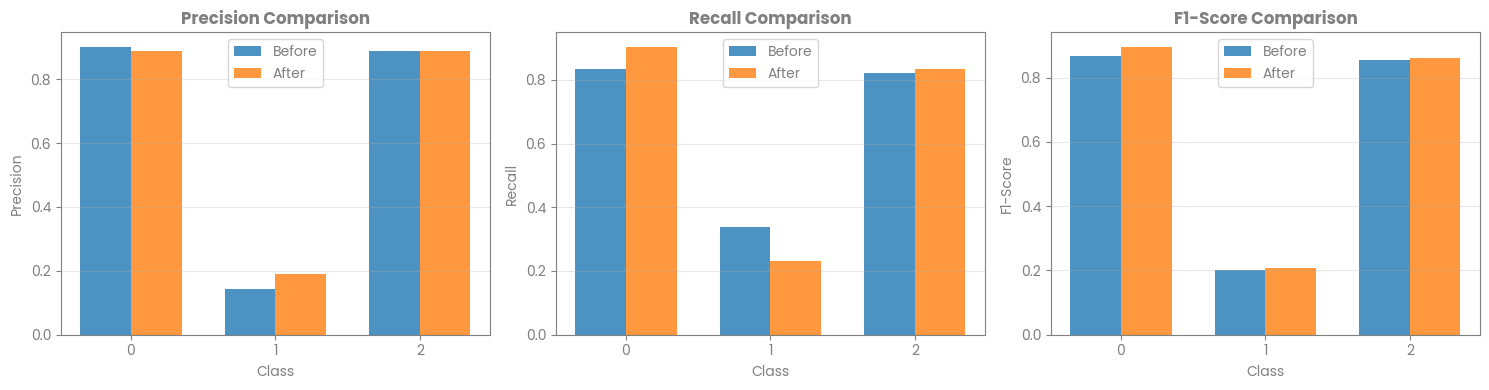

In [ ]:
# Bar chart perbandingan metrics per class
precision_before, recall_before, f1_before, _ = precision_recall_fscore_support(y_val, y_pred_baseline, labels=classes, zero_division=0)
precision_after, recall_after, f1_after, _ = precision_recall_fscore_support(y_val, y_pred_tuned, labels=classes, zero_division=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

x = np.arange(n_classes)
width = 0.35

# Precision
axes[0].bar(x - width/2, precision_before, width, label='Before', alpha=0.8)
axes[0].bar(x + width/2, precision_after, width, label='After', alpha=0.8)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Recall
axes[1].bar(x - width/2, recall_before, width, label='Before', alpha=0.8)
axes[1].bar(x + width/2, recall_after, width, label='After', alpha=0.8)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# F1-Score
axes[2].bar(x - width/2, f1_before, width, label='Before', alpha=0.8)
axes[2].bar(x + width/2, f1_after, width, label='After', alpha=0.8)
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(classes)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# **6. Final Model Evaluation**

The optimized model is evaluated on the held-out test set to assess generalization performance. Bootstrap validation estimates confidence intervals and verifies model stability across different data samples.

## **6.1. Test Set Performance**

Final model predictions are generated on the test set using calibrated thresholds. Comprehensive metrics including precision, recall, F1-score, and confusion matrices are computed to evaluate performance across all classes.

In [ ]:
print("Making Predictions on Test Set")
y_proba_test = final_pipeline.predict_proba(X_test)
y_pred_test = predict_with_thresholds(y_proba_test, best_thresholds)

print("✓ Predictions completed")
print(f"  Test set size: {len(y_test)}")
print(f"  Predictions shape: {y_pred_test.shape}")

Making Predictions on Test Set
✓ Predictions completed
  Test set size: 19831
  Predictions shape: (19831,)


In [ ]:
# BASIC METRICS COMPARISON
print("CLASSIFICATION REPORTS")
print(classification_report(y_test, y_pred_test, digits=4))

CLASSIFICATION REPORTS
              precision    recall  f1-score   support

           0     0.8522    0.9594    0.9026     11992
           1     0.2042    0.0954    0.1301      1027
           2     0.9233    0.7930    0.8532      6812

    accuracy                         0.8575     19831
   macro avg     0.6599    0.6159    0.6286     19831
weighted avg     0.8431    0.8575    0.8456     19831



In [ ]:
# PER-CLASS METRICS COMPARISON
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, labels=classes, zero_division=0)

# Create detailed comparison DataFrame
comparison_df = pd.DataFrame({
    'Class': classes,
    'Support': support,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
})

print(comparison_df.to_string(index=False))

 Class  Support  Precision   Recall       F1
     0    11992   0.852222 0.959390 0.902636
     1     1027   0.204167 0.095424 0.130060
     2     6812   0.923261 0.793012 0.853194


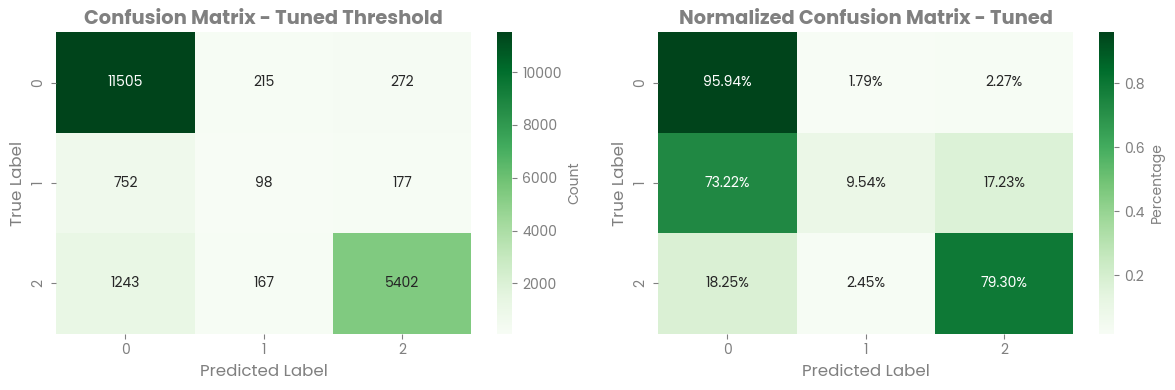

In [ ]:
# CONFUSION MATRICES
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Tuned Threshold - Count
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Tuned Threshold', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Tuned Threshold - Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Normalized Confusion Matrix - Tuned', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

## **6.2. Cross-validation pada Test Set**

Bootstrap resampling validates model stability by evaluating performance across 100 random samples of the test set. Confidence intervals quantify prediction reliability and identify potential variance issues.

FINAL STABILITY CHECK

Bootstrap F1-Score (n=100):
  Mean: 0.6288
  Std: 0.0041
  95% CI: [0.6206, 0.6360]


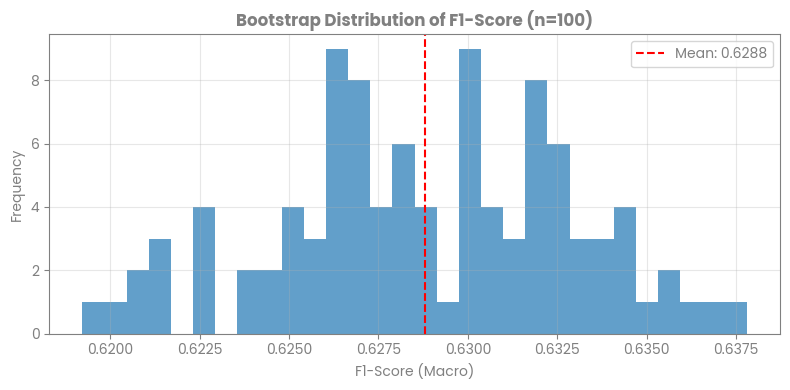

In [ ]:
# Verify model stability
print("FINAL STABILITY CHECK")

# Bootstrap validation
n_bootstrap = 100
bootstrap_scores = []

for i in range(n_bootstrap):
    # Resample test set
    X_boot, y_boot = resample(X_test, y_test, random_state=i, stratify=y_test)
    y_proba_boot = final_pipeline.predict_proba(X_boot)
    y_pred_boot = predict_with_thresholds(y_proba_boot, best_thresholds)

    score = f1_score(y_boot, y_pred_boot, average='macro')
    bootstrap_scores.append(score)

print(f"\nBootstrap F1-Score (n={n_bootstrap}):")
print(f"  Mean: {np.mean(bootstrap_scores):.4f}")
print(f"  Std: {np.std(bootstrap_scores):.4f}")
print(f"  95% CI: [{np.percentile(bootstrap_scores, 2.5):.4f}, {np.percentile(bootstrap_scores, 97.5):.4f}]")

plt.figure(figsize=(8, 4))
plt.hist(bootstrap_scores, bins=30, alpha=0.7)
plt.axvline(np.mean(bootstrap_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bootstrap_scores):.4f}')
plt.xlabel('F1-Score (Macro)')
plt.ylabel('Frequency')
plt.title(f'Bootstrap Distribution of F1-Score (n={n_bootstrap})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **7. Model Interpretation & Analysis**

The trained model is analyzed to understand prediction patterns, feature importance, and error characteristics. This analysis provides actionable insights for model improvement and identifies potential limitations.

## **7.1 Feature Importance Analysis**

TF-IDF feature weights from Logistic Regression coefficients reveal the most influential words for each sentiment class. These features provide linguistic insights into sentiment indicators in Indonesian app reviews.

In [ ]:
# Extract top features dari TF-IDF
tfidf_vectorizer = final_pipeline.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names_out()
clf = final_pipeline.named_steps['clf']

# Top features per class
n_top = 20
for i, class_name in enumerate(classes):
    coef = clf.coef_[i]
    top_indices = np.argsort(coef)[-n_top:][::-1]
    top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]

    print(f"\nTop {n_top} features untuk class '{class_name}':")
    for feature, weight in top_features:
        print(f"  {feature}: {weight:.4f}")


Top 20 features untuk class '0':
  bayar: 3.7929
  login: 3.2875
  tipu: 3.1150
  tidak: 3.0273
  gabisa: 2.7308
  sampah: 2.7132
  buruk: 2.6378
  premium: 2.4608
  gk: 2.4284
  kode: 2.3908
  gajelas: 2.3866
  tolol: 2.3538
  malah: 2.2558
  aneh: 2.2391
  nomor: 2.1002
  not_banget: 2.0927
  scam: 2.0292
  padahal: 2.0266
  code: 2.0016
  kecewa: 1.9860

Top 20 features untuk class '1':
  kenapa: 2.6502
  horror: 2.3997
  pending: 2.1805
  lagi aplikasi: 2.1633
  lumayan: 2.1019
  aplikasi gila: 2.0768
  netral: 2.0647
  kotor: 2.0505
  pdahal: 2.0382
  sata: 1.9226
  aga: 1.9154
  story: 1.9151
  sering: 1.8773
  not_lgi: 1.8260
  masa suruh: 1.8170
  telekram: 1.8150
  sedikit: 1.8047
  lite: 1.7997
  cepat respon: 1.7950
  kadang: 1.7941

Top 20 features untuk class '2':
  makasih: 2.0980
  good: 1.9448
  love: 1.8663
  mantapp: 1.8203
  bagus sih: 1.8026
  bagus sekali: 1.7610
  thanks: 1.7549
  sukses: 1.7424
  best: 1.7157
  bagus: 1.7089
  seruu: 1.6856
  bisnis: 1.6778
  no

## **7.2 Error Analysis**

Misclassified samples are examined to identify common error patterns. The analysis reveals which sentiment pairs are most frequently confused and provides examples for qualitative assessment.

In [ ]:
# Analisis prediksi yang salah
errors_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred_test,
    'correct': y_test == y_pred_test
})

# Filter kesalahan prediksi
misclassified = errors_df[~errors_df['correct']]

print(f"Total misclassified: {len(misclassified)} / {len(errors_df)} ({len(misclassified)/len(errors_df)*100:.2f}%)")

# Confusion pairs analysis
error_pairs = Counter(zip(misclassified['true_label'], misclassified['predicted_label']))

print("\nMost common misclassification patterns:")
for (true, pred), count in error_pairs.most_common(5):
    print(f"  True: {classes[true]} → Predicted: {classes[pred]}: {count} cases")
    examples = misclassified[(misclassified['true_label'] == true) &
                            (misclassified['predicted_label'] == pred)].head(3)
    for idx, row in examples.iterrows():
        print(f"    Example: {row['text'][:100]}...")

Total misclassified: 2826 / 19831 (14.25%)

Most common misclassification patterns:
  True: 2 → Predicted: 0: 1243 cases
    Example: wanto jf...
    Example: telegram tolong baik bug login nya padahal nomer baru kode kirim ke chat telegram tidak NOT_nalar NO...
    Example: dear siri will not misuses the telegram features againits my personal number so please sir i humbly ...
  True: 1 → Predicted: 0: 752 cases
    Example: ngebug sangat sinyal nya buat log in saja gk bisa hmm...
    Example: aplikasi nya bagus kk tapi kenapa mau daftar og gk bisa dapet kode verifikasi nya dari telegram moho...
    Example: ini bagaimana ya kenapa saya tidak NOT_dapat NOT_code...
  True: 0 → Predicted: 2: 272 cases
    Example: tolong ya di baik data yang di unduhga bisa di buka langsung hilanh kehpus sendiriga nyaman...
    Example: ajar tentang telegram...
    Example: jos...
  True: 0 → Predicted: 1: 215 cases
    Example: kenapa gk dapet kode nya...
    Example: agak lambat proses loadingnya...
  

## **7.3. Confidence Analysis**

Prediction confidence scores are analyzed to understand model certainty. Low-confidence predictions are identified as candidates for human review or additional data collection.

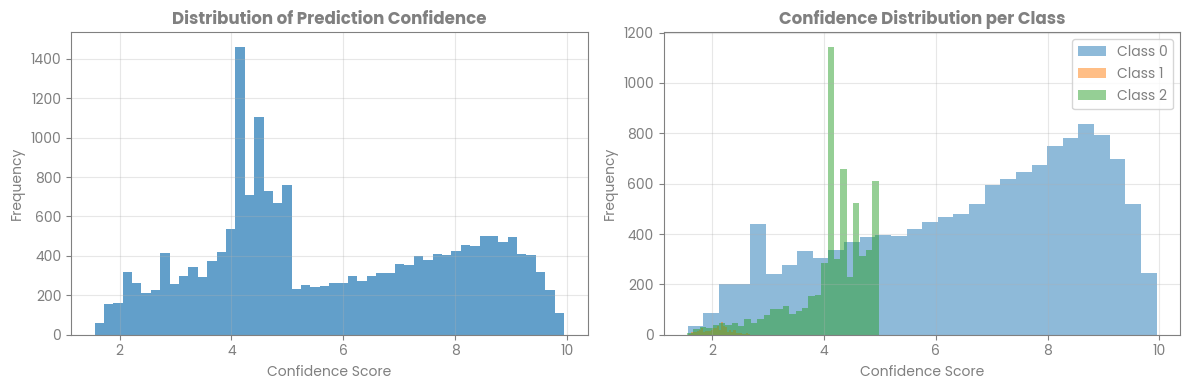


Low confidence predictions: 0 (0.00%)

Examples of low confidence predictions:
Empty DataFrame
Columns: [text, true_label, predicted_label, confidence]
Index: []


In [ ]:
# Confidence scores analysis
confidence_scores = np.max(y_proba_test / best_thresholds, axis=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=50, alpha=0.7)
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i, class_name in enumerate(classes):
    class_mask = y_pred_test == i
    plt.hist(confidence_scores[class_mask], bins=30, alpha=0.5, label=f'Class {class_name}')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution per Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Low confidence predictions
low_confidence_threshold = 0.5
low_conf_mask = confidence_scores < low_confidence_threshold
low_conf_df = errors_df[low_conf_mask].copy()
low_conf_df['confidence'] = confidence_scores[low_conf_mask]

print(f"\nLow confidence predictions: {len(low_conf_df)} ({len(low_conf_df)/len(errors_df)*100:.2f}%)")
print("\nExamples of low confidence predictions:")
print(low_conf_df[['text', 'true_label', 'predicted_label', 'confidence']].head(10))

# **8. Model Saving & Deployment Preparation**

The final model, calibrated thresholds, and metadata are saved for production deployment. A reusable inference function is created and tested to ensure consistent predictions in production environments.

## **8.1. Save Model & Artifacts**

The trained pipeline, threshold values, class mappings, and model metadata are serialized and saved to Google Drive with timestamps for version control.

In [ ]:
# Save model
model_path = 'sentiment_model.pkl'
joblib.dump(final_pipeline, model_path)
print(f"✓ Model saved: {model_path}")

# Save thresholds
thresholds_path = 'thresholds.pkl'
joblib.dump(best_thresholds, thresholds_path)
print(f"✓ Thresholds saved: {thresholds_path}")

# Save class mapping
class_mapping = {i: class_name for i, class_name in enumerate(classes)}
mapping_path = 'class_mapping.pkl'
joblib.dump(class_mapping, mapping_path)
print(f"✓ Class mapping saved: {mapping_path}")

# Save model metadata
metadata = {
    'test_f1_macro': f1_score(y_test, y_pred_test, average='macro'),
    'test_accuracy': accuracy_score(y_test, y_pred_test),
    'best_params': study.best_params,
    'best_thresholds': best_thresholds.tolist(),
    'tfidf_params': tfidf_params,
    'classes': classes.tolist()
}

metadata_path = 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {metadata_path}")

## **8.2. Create Inference Function**

A standalone prediction function is implemented and tested with sample reviews. This function loads the model artifacts and returns predictions with confidence scores for production use.

In [ ]:
def load_model_and_predict(text, model_path, thresholds_path, class_mapping_path):
    model = joblib.load(model_path)
    thresholds = joblib.load(thresholds_path)
    class_mapping = joblib.load(class_mapping_path)

    proba = model.predict_proba([text])[0]

    adjusted_proba = proba / thresholds
    pred_class_idx = np.argmax(adjusted_proba)
    pred_class = class_mapping[pred_class_idx]
    confidence = adjusted_proba[pred_class_idx]

    return {
        'prediction': pred_class,
        'confidence': confidence,
        'probabilities': {class_mapping[i]: p for i, p in enumerate(proba)}
    }

# Test inference function
test_reviews = ["aplikasi sangat bagus dan mudah digunakan", "aplikasi buruk sekali, tidak bisa dibuka", "biasa saja"]

print("TESTING INFERENCE FUNCTION")
for review in test_reviews:
    result = load_model_and_predict(review, model_path, thresholds_path, mapping_path)
    print(f"\nReview: {review}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {result['probabilities']}")

TESTING INFERENCE FUNCTION

Review: aplikasi sangat bagus dan mudah digunakan
Prediction: 2
Confidence: 4.8972
Probabilities: {np.int64(0): np.float64(0.005614190694443977), np.int64(1): np.float64(0.01495470214834511), np.int64(2): np.float64(0.9794311071572109)}

Review: aplikasi buruk sekali, tidak bisa dibuka
Prediction: 0
Confidence: 7.5498
Probabilities: {np.int64(0): np.float64(0.7549795239021079), np.int64(1): np.float64(0.08662966238620967), np.int64(2): np.float64(0.15839081371168243)}

Review: biasa saja
Prediction: 1
Confidence: 2.0487
Probabilities: {np.int64(0): np.float64(0.12772088004825133), np.int64(1): np.float64(0.717055648430136), np.int64(2): np.float64(0.15522347152161264)}
